In [2]:
import numpy as np

In [3]:
np.zeros([12, 3], dtype=int)

array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]])

In [1]:
import os
import numpy as np
# import working directory to check functions
os.chdir('/Users/schiend/Desktop/DOHERTY/R-workspace/cecelia/inst')

# config
import py.config_utils as cfg

%load_ext autoreload
%autoreload 2

In [2]:
base_dir = '/Volumes/Analysis_SSD/Dominik/cecelia/projects/pEdOoZ/ANALYSIS/'
zero_dir = os.path.join(base_dir, '0/fhz81P/')
im_path = os.path.join(zero_dir, 'ccidImage.ome.zarr')
version_num = 2
task_dir = os.path.join(base_dir, str(version_num), 'fhz81P')

In [3]:
from py.napari_utils import NapariUtils

napari_utils = NapariUtils()
napari_utils.viewer = None
napari_utils.open_viewer()
napari_utils.task_dir = task_dir

Could not find Java JRE compatible with x86_64 architecture


In [4]:
channel_names = [
    'X127I_I127','X132Xe_Xe132','X138Ba_Ba138','X190BCKG_BCKG190',
    'X191Ir_Ir191','X193Ir_Ir193','X195Pt_Pt195','X208Pb_Pb208',
    'X80ArAr_ArAr80','B-Catenin_Ho165','CCR7_Gd158','CD14_Nd144',
    'CD20_Dy161','CD29_Sm149','CD3_Er170','CD31_Sm147','CD4_Gd156',
    'CD40_Er168','CD45_Sm152','CD45RA_Er166','CD45RO_Yb173',
    'CD68_Tb159','CD8a_Dy162','cleaved-Caspase3_Yb172','CollagenI_Tm169',
    'FoxP3_Gd155','GranzymeB_Er167','Histone-H3_Yb176','HLA-DR_Yb174',
    'ICOS_Nd148','Ki67_Nd143','LAG3_Eu153','OX40_Eu151','PDL1_Nd150',
    'pERK1-2_Yb171','S100_Lu175','SMA_Pr141','SOX10_Dy164',
    'TIM3_Sm154','VISTA_Gd160'
]

In [5]:
napari_utils.open_image(
    im_path,
    use_channel_axis = True,
    as_dask = False,
    visible = False,
    squeeze = True,
    channel_names = channel_names
)

In [6]:
from apoc import PixelClassifier

In [7]:
# check classifier
cl_path = os.path.join(base_dir, '2', 'IIIII0', 'cl', 'pix', 'imc_ki67.cl')

In [8]:
cl_channel_names = ['Histone-H3_Yb176', 'Ki67_Nd143']

In [9]:
cl_channels = [channel_names.index(x) for x in cl_channel_names]

In [10]:
import py.zarr_utils as zarr_utils
import py.ome_xml_utils as ome_xml_utils
from py.dim_utils import DimUtils

In [11]:
# get image information
im_dat, zarr_group_info = zarr_utils.open_as_zarr(im_path, as_dask = False)

# get OME-XML
omexml = ome_xml_utils.parse_meta(im_path)

# create dim utils for image
dim_utils = DimUtils(omexml, use_channel_axis = True)
dim_utils.calc_image_dimensions(im_dat[0].shape)

im = zarr_utils.fortify(im_dat[0])

In [12]:
# load channels for classification
images = list()

# ensure that channels are in ascending order
cl_channels.sort()
for x in cl_channels:
    slices = [slice(None) for _ in range(len(dim_utils.im_dim))]
    slices[napari_utils.dim_utils.dim_idx('C')] = x

    images.append(
        np.squeeze(zarr_utils.fortify(im[tuple(slices)]))
    )

In [13]:
cl_segmenter = PixelClassifier(opencl_filename = cl_path)

In [14]:
import pyclesperanto_prototype as cle

In [15]:
cle.get_device()

<Iris Pro on Platform: Apple (2 refs)>

In [16]:
cl_result = cl_segmenter.predict(image = images)

cl.OCLArray([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint32)
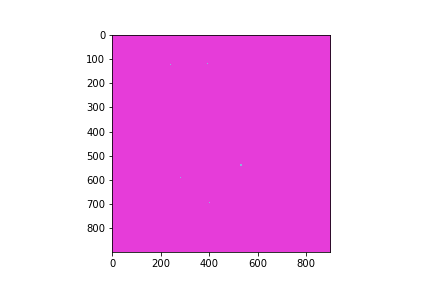

In [17]:
cl_result

In [ ]:
import modules.tasks.sources.pixcl.py.apply_classifier as apply_classifier

# define params
params = {
    'ccia': {
    },
    'taskDir': task_dir,
    'imPath': im_path,
    'clChannels': [0, 3],
    'clPath': cl_path,
    'normaliseImage': False,
    'normPercentile': 99.98,
    'saveMeshes': True,
    'minObjectSize': 50
}

# run segmentation
apply_classifier.run(params)